# TM10007 Assignment template

In [12]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
# Import functions
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from brats.load_data import load_data
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Import data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 167
The number of columns: 725


In [3]:
remove_features = data.T[data.isna().sum(axis=0) < 130]
removed_features = remove_features.T
print(f'The number of samples: {len(removed_features)}')
print(f'The number of columns: {len(removed_features.columns)}')

The number of samples: 167
The number of columns: 705


In [4]:
#impute Nans

label = removed_features['label'].to_numpy() #extract labels
features = removed_features.drop('label', axis=1) #dropped laatste kolom (labels)
replace_div = features.replace(r'#DIV/0!', 'nan', regex=True) #DIV's worden vervangen door nan 
replace_inf = replace_div.replace(np.inf, np.nan, regex=True) #inf wordt vervangen door nan

feature_names = list(replace_inf.columns) #extract feature names
imputer = KNNImputer(n_neighbors=10) #definieert functie K-nearest neighbor imputer
clean_data = imputer.fit_transform(replace_inf) #alle nan's worden vervangen op basis van k-NN imputer

In [5]:
#convert labels to true and false
labels = label=='GBM'

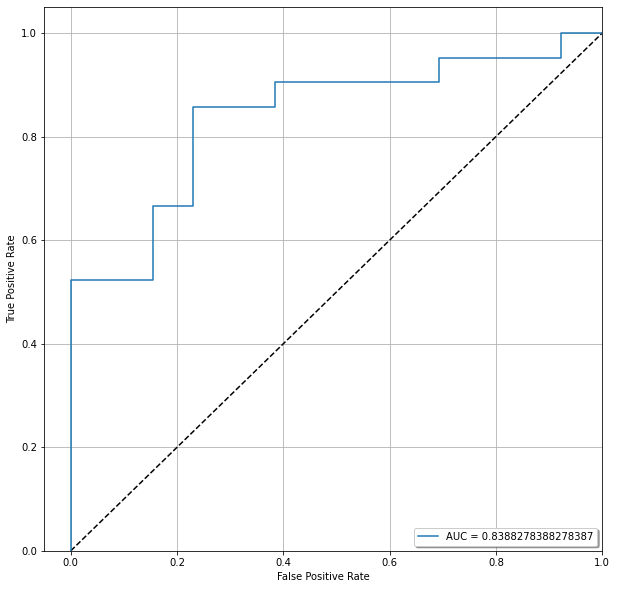

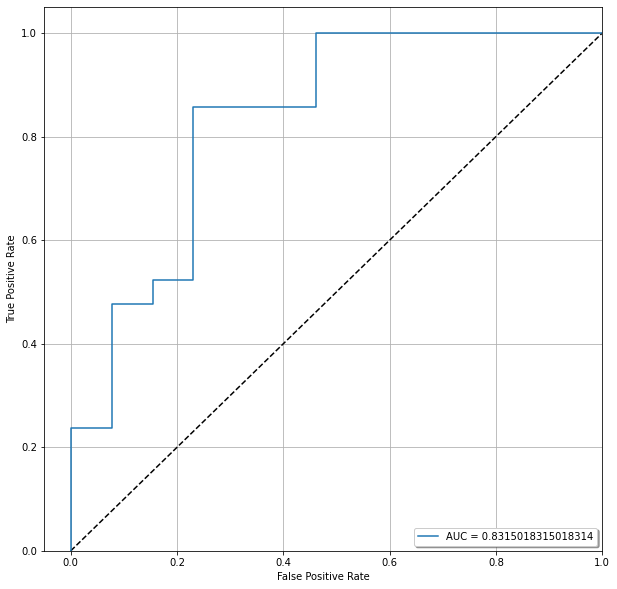

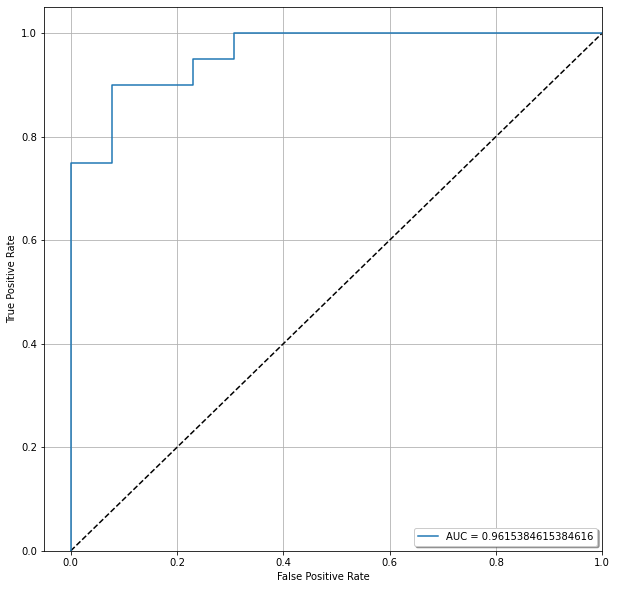

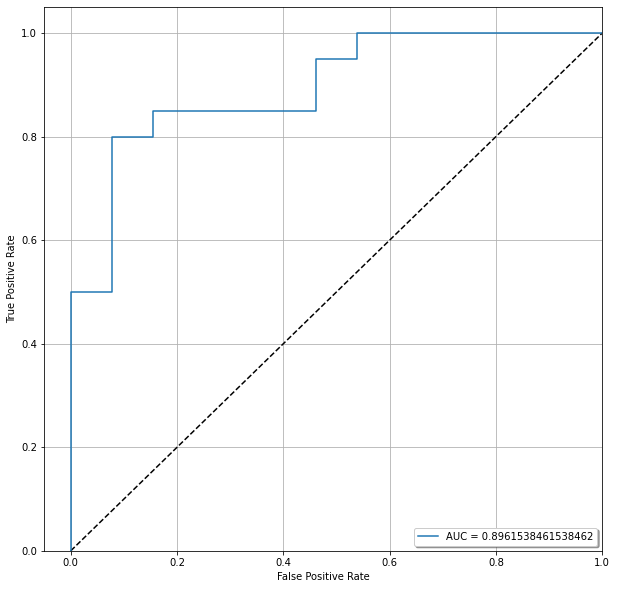

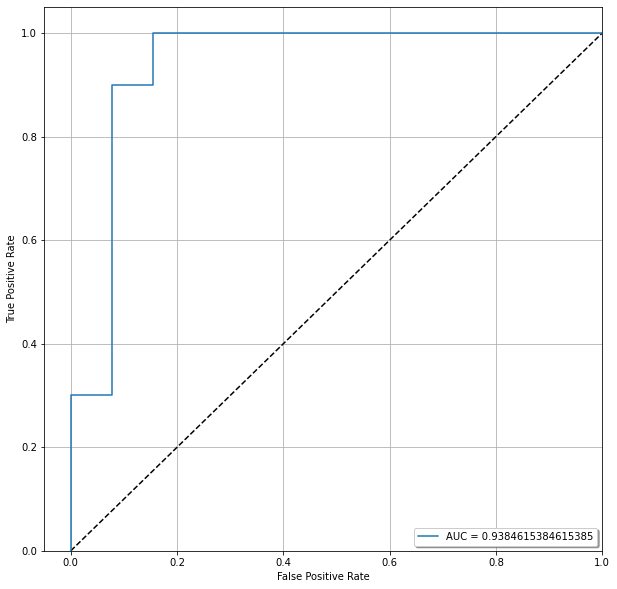

In [15]:
rskf = StratifiedKFold(n_splits=5) #ik heb random state verwijderd, daardoor worden steeds dezelfde r splits gemaakt

for train_index, test_index in rskf.split(features, label):
    data_train, data_test = clean_data[train_index], clean_data[test_index]
    label_train, label_test = labels[train_index], labels[test_index]
    # Create a pipeline
    pipe = Pipeline([('scalar',StandardScaler()),('pca',PCA(n_components=0.95)),('classifier',RandomForestClassifier())])
    # Create dictionary with candidate learning algorithms and their hyperparameters
    grid_param = [{"classifier": [RandomForestClassifier()],
                   "classifier__n_estimators": [10, 100, 1000],
                   "classifier__max_depth":[5,8,15,25,30,None],
                   "classifier__min_samples_leaf":[2,5,10,15,100],
                   "classifier__max_leaf_nodes": [2, 5,10]}]
    # create a gridsearch of the pipeline, the fit the best model
    skf = StratifiedKFold(n_splits=7)
    gridsearch = GridSearchCV(pipe, grid_param, cv=skf, verbose=0,n_jobs=-1) # Fit grid search
    best_model = gridsearch.fit(data_train,label_train)

    # get roc/auc info
    y_score = best_model.predict_proba(data_test)[:,1]
    fpr = dict()
    tpr = dict()
    fpr, tpr, _ = roc_curve(label_test, y_score)

    roc_auc = dict()
    roc_auc = auc(fpr, tpr)

    # # make the plot
    # plt.figure(figsize=(10,10))
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlim([-0.05, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.grid(True)
    # plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
    # plt.legend(loc="lower right", shadow=True, fancybox =True) 
    # plt.show()
